In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-28 09:59:51.803926: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 09:59:52.340150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-28 09:59:52.340224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-28 09:59:52.340232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

In [2]:
# images used to generate the covariance matrix
num_images = 10000
num_patches = 10000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 10

# patch_size = 5
# sample_size = 10

photons_per_pixel = 300

channels = ['LED119', 'DPC_Right', 'Brightfield']
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']


image_samples_gp = {}
image_samples_pcnn = {}
noisy_patches_by_channel = {}
images_by_channel = {}

for channel_index, channel in tqdm(enumerate(channels), desc='Fitting models and sampling'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    images = None # save memory

    print('getting patches')
    noisy_patches = extract_patches(noisy_images, patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('fitting stationary GP')
    gp = StationaryGaussianProcess(noisy_patches, eigenvalue_floor=1e-1)
    _ = gp.fit(noisy_patches, verbose=True)
    cov_mat = gp.get_cov_mat()

    print('fitting PixelCNN')
    pcnn = PixelCNN()
    pcnn.fit(noisy_patches, max_epochs=25, verbose=True)

    print('generating samples for PixelCNN')
    image_samples_pcnn[channel] = pcnn.generate_samples(num_samples, sample_size, seed=channel_index * 1000, verbose=True)

    print('generating samples for stationary GP')
    image_samples_gp[channel] = gp.generate_samples(num_samples, sample_size,seed=channel_index * 1000, verbose=True)


Fitting models and sampling: 0it [00:00, ?it/s]

getting patches
fitting stationary GP


2023-10-28 10:03:16.979863: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 18.13



Epoch 1: 100%|███████████████████████████████████████| 1/1 [01:21<00:00, 81.82s/it]


Epoch 1: validation NLL: nan



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 2: validation NLL: nan



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 3: validation NLL: nan



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 4: validation NLL: nan



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 5: validation NLL: nan
fitting PixelCNN
Initial validation NLL: 66.51



Epoch 1: 100%|███████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 1: validation NLL: 4.80



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.13it/s]


Epoch 2: validation NLL: 4.62



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.26it/s]


Epoch 3: validation NLL: 4.63



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.34it/s]


Epoch 4: validation NLL: 4.56



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:10<00:00,  9.89it/s]


Epoch 5: validation NLL: 4.58



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.25it/s]


Epoch 6: validation NLL: 4.55



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.04it/s]


Epoch 7: validation NLL: 4.54



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.31it/s]


Epoch 8: validation NLL: 4.55



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:09<00:00, 10.31it/s]


Epoch 9: validation NLL: 4.57



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.87it/s]


Epoch 10: validation NLL: 4.56



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.20it/s]


Epoch 11: validation NLL: 4.54



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch 12: validation NLL: 4.53



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.19it/s]


Epoch 13: validation NLL: 4.53



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.28it/s]


Epoch 14: validation NLL: 4.55



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.10it/s]


Epoch 15: validation NLL: 4.52



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.20it/s]


Epoch 16: validation NLL: 4.53



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.78it/s]


Epoch 17: validation NLL: 4.54



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


Epoch 18: validation NLL: 4.52



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.10it/s]


Epoch 19: validation NLL: 4.52



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.32it/s]


Epoch 20: validation NLL: 4.52



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.32it/s]


Epoch 21: validation NLL: 4.52



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.98it/s]


Epoch 22: validation NLL: 4.52



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.21it/s]


Epoch 23: validation NLL: 4.58



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.09it/s]


Epoch 24: validation NLL: 4.51



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.87it/s]


Epoch 25: validation NLL: 4.51
generating samples for PixelCNN



Generating PixelCNN samples: 100%|█████████████████| 80/80 [52:46<00:00, 39.58s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|████████████| 80/80 [06:49<00:00,  5.12s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████| 80/80 [02:11<00:00,  1.64s/it]
Fitting models and sampling: 1it [1:11:48, 4308.43s/it]

getting patches
fitting stationary GP
Initial validation NLL: 4.43



Epoch 1: 100%|███████████████████████████████████████| 1/1 [00:58<00:00, 58.93s/it]


Epoch 1: validation NLL: nan



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 2: validation NLL: nan



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 3: validation NLL: nan



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 4: validation NLL: nan



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch 5: validation NLL: nan
fitting PixelCNN
Initial validation NLL: 44.81



Epoch 1: 100%|███████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 1: validation NLL: 4.47



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:10<00:00,  9.27it/s]


Epoch 2: validation NLL: 4.41



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.40it/s]


Epoch 3: validation NLL: 4.40



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch 4: validation NLL: 4.40



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 5: validation NLL: 4.40



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:10<00:00,  9.60it/s]


Epoch 6: validation NLL: 4.40



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


Epoch 7: validation NLL: 4.39



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


Epoch 8: validation NLL: 4.39



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 9: validation NLL: 4.39



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.16it/s]


Epoch 10: validation NLL: 4.39



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


Epoch 11: validation NLL: 4.39



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


Epoch 12: validation NLL: 4.39



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.48it/s]


Epoch 13: validation NLL: 4.39



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  7.81it/s]


Epoch 14: validation NLL: 4.40



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.15it/s]


Epoch 15: validation NLL: 4.38



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 16: validation NLL: 4.38



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


Epoch 17: validation NLL: 4.38



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 18: validation NLL: 4.39



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.05it/s]


Epoch 19: validation NLL: 4.38



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


Epoch 20: validation NLL: 4.38



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


Epoch 21: validation NLL: 4.38



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 22: validation NLL: 4.38



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.56it/s]


Epoch 23: validation NLL: 4.38



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 24: validation NLL: 4.38



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 25: validation NLL: 4.38
generating samples for PixelCNN



Generating PixelCNN samples: 100%|█████████████████| 80/80 [56:12<00:00, 42.16s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|████████████| 80/80 [05:18<00:00,  3.98s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████| 80/80 [01:56<00:00,  1.45s/it]
Fitting models and sampling: 2it [2:24:56, 4355.26s/it]

getting patches
fitting stationary GP
Initial validation NLL: 59.19



Epoch 1: 100%|███████████████████████████████████████| 1/1 [00:56<00:00, 56.42s/it]


Epoch 1: validation NLL: nan



Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 2: validation NLL: nan



Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 3: validation NLL: nan



Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 4: validation NLL: nan



Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 5: validation NLL: nan
fitting PixelCNN
Initial validation NLL: 18.20



Epoch 1: 100%|███████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 1: validation NLL: 4.30



Epoch 2: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


Epoch 2: validation NLL: 4.29



Epoch 3: 100%|███████████████████████████████████| 100/100 [00:10<00:00,  9.95it/s]


Epoch 3: validation NLL: 4.29



Epoch 4: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch 4: validation NLL: 4.29



Epoch 5: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


Epoch 5: validation NLL: 4.29



Epoch 6: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 6: validation NLL: 4.29



Epoch 7: 100%|███████████████████████████████████| 100/100 [00:11<00:00,  8.83it/s]


Epoch 7: validation NLL: 4.29



Epoch 8: 100%|███████████████████████████████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 8: validation NLL: 4.29



Epoch 9: 100%|███████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Epoch 9: validation NLL: 4.29



Epoch 10: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Epoch 10: validation NLL: 4.29



Epoch 11: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  7.81it/s]


Epoch 11: validation NLL: 4.29



Epoch 12: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.52it/s]


Epoch 12: validation NLL: 4.29



Epoch 13: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


Epoch 13: validation NLL: 4.29



Epoch 14: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Epoch 14: validation NLL: 4.29



Epoch 15: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.38it/s]


Epoch 15: validation NLL: 4.29



Epoch 16: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s]


Epoch 16: validation NLL: 4.29



Epoch 17: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


Epoch 17: validation NLL: 4.29



Epoch 18: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


Epoch 18: validation NLL: 4.29



Epoch 19: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


Epoch 19: validation NLL: 4.29



Epoch 20: 100%|██████████████████████████████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 20: validation NLL: 4.29



Epoch 21: 100%|██████████████████████████████████| 100/100 [00:11<00:00,  8.81it/s]


Epoch 21: validation NLL: 4.29



Epoch 22: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


Epoch 22: validation NLL: 4.29



Epoch 23: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


Epoch 23: validation NLL: 4.29



Epoch 24: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch 24: validation NLL: 4.28



Epoch 25: 100%|██████████████████████████████████| 100/100 [00:09<00:00, 10.52it/s]


Epoch 25: validation NLL: 4.29
generating samples for PixelCNN



Generating PixelCNN samples: 100%|█████████████████| 80/80 [56:08<00:00, 42.11s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|████████████| 80/80 [03:42<00:00,  2.78s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████| 80/80 [01:23<00:00,  1.05s/it]
Fitting models and sampling: 3it [3:36:06, 4322.15s/it]


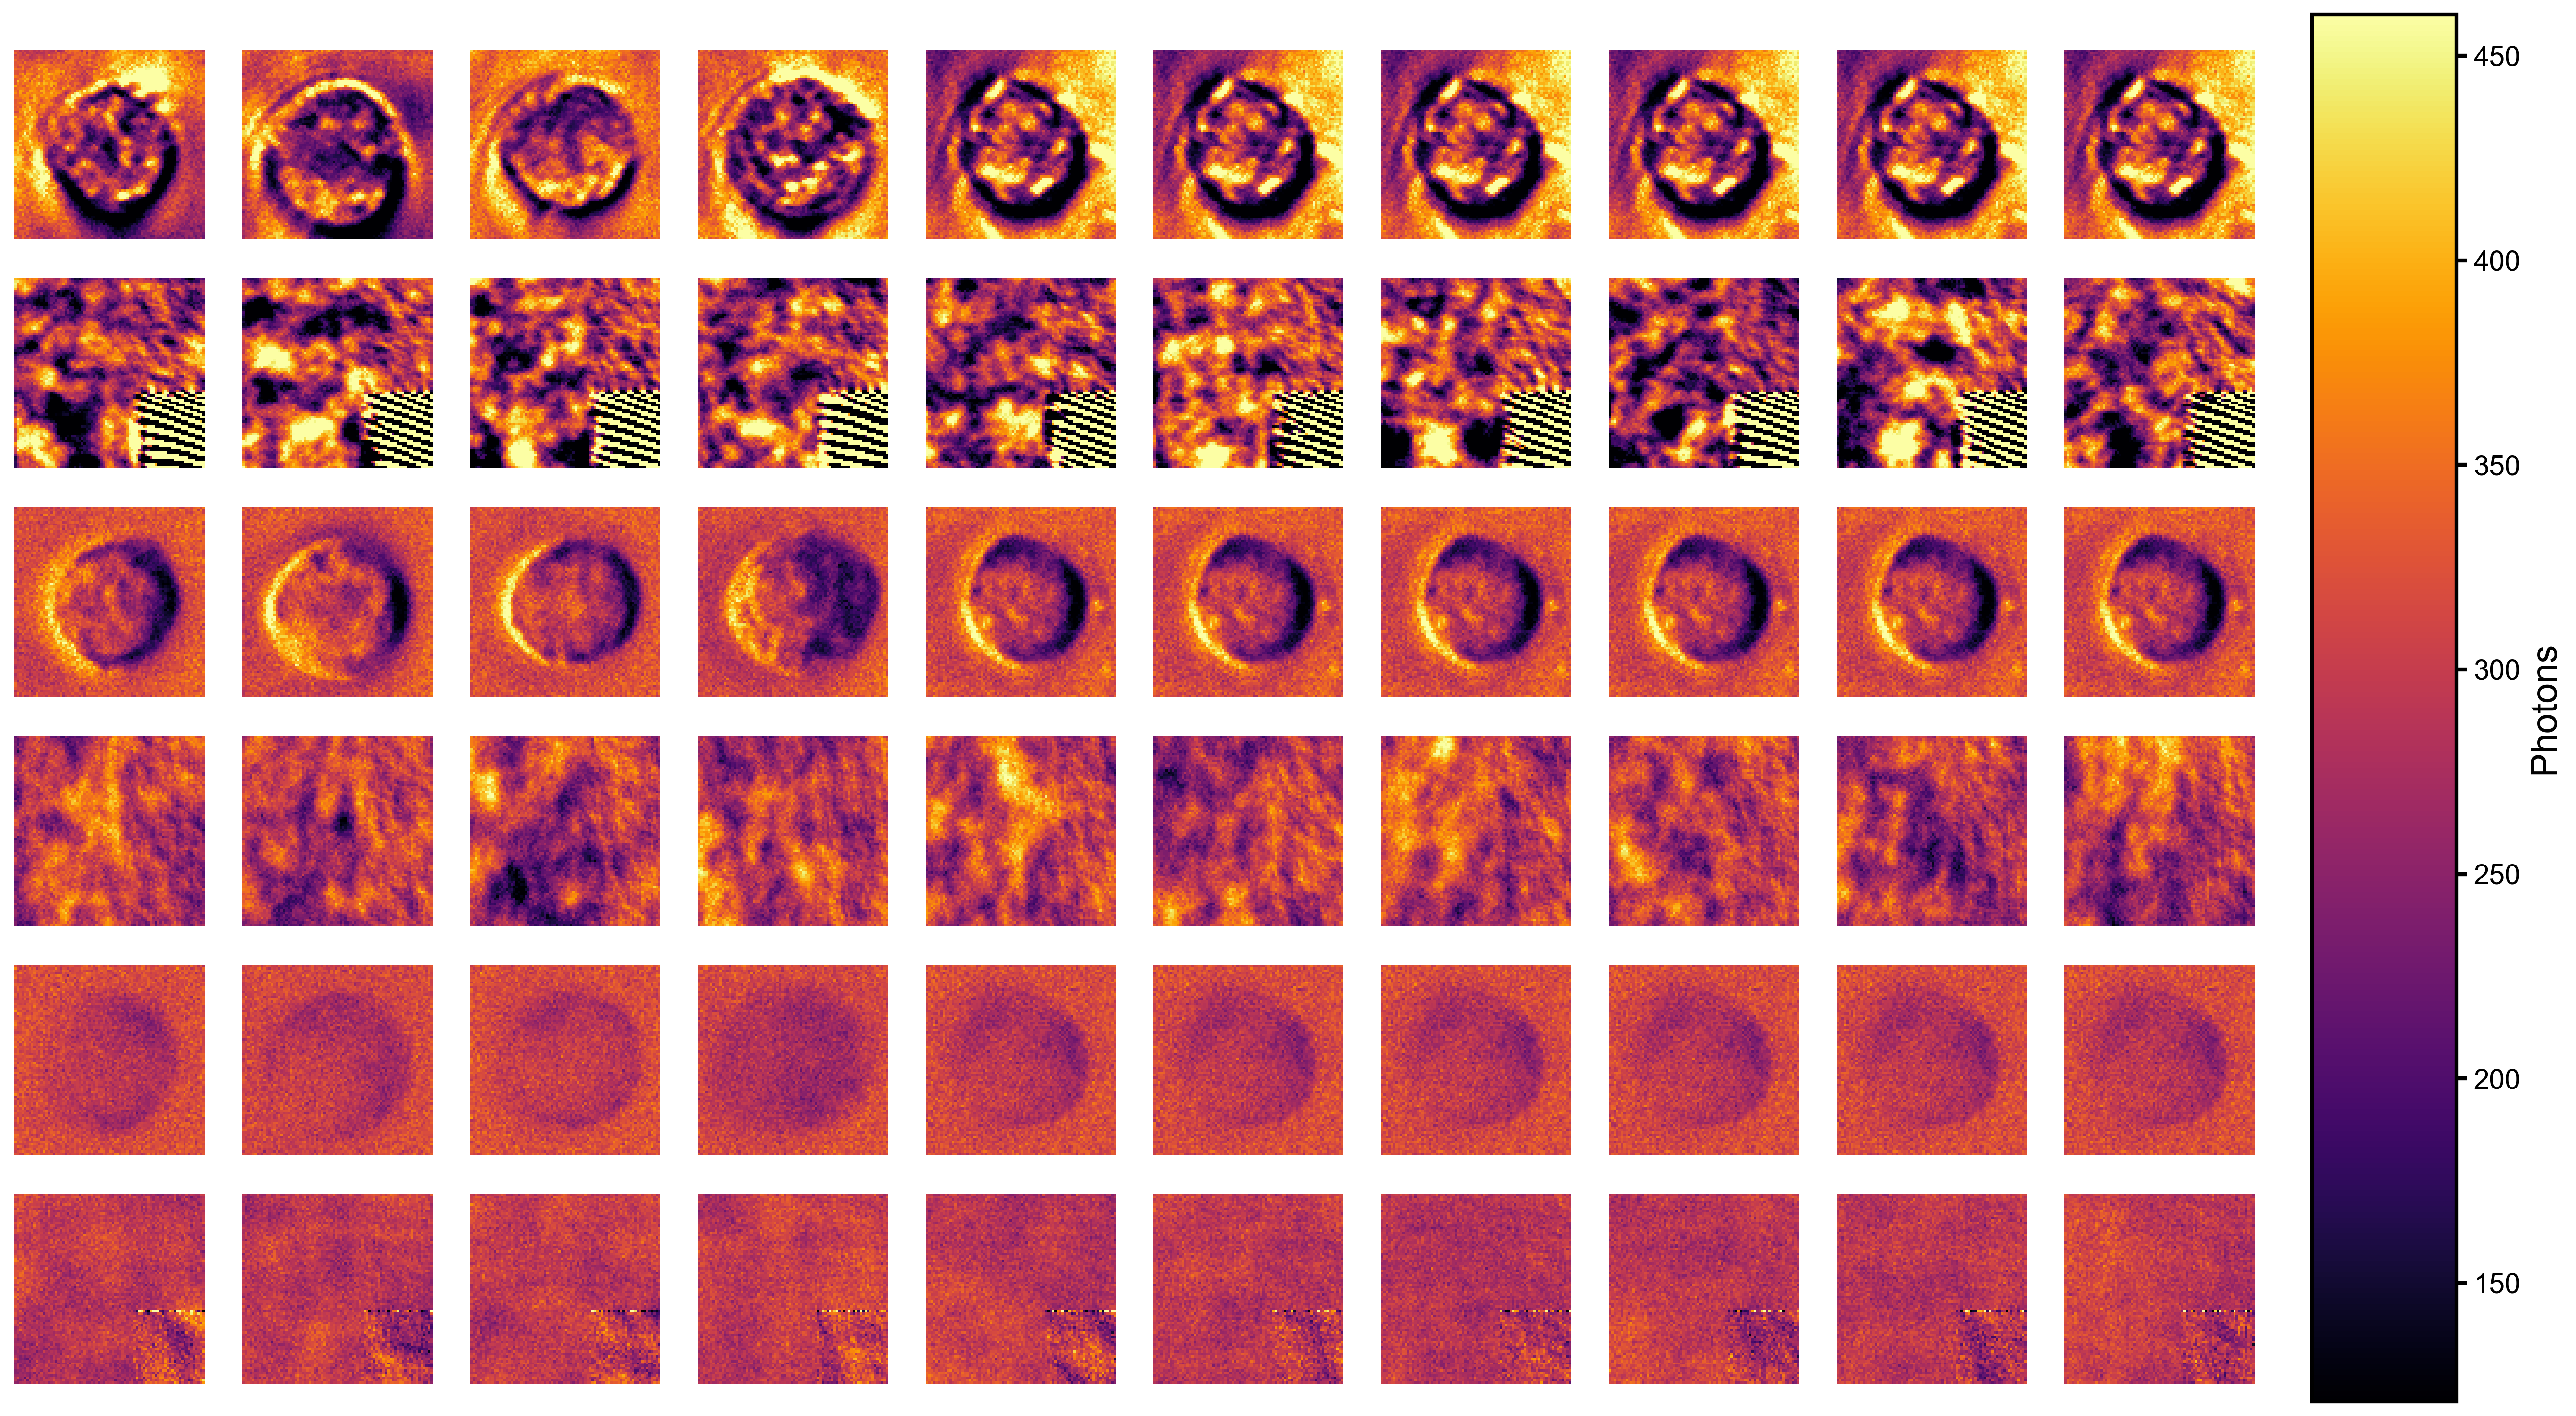

In [3]:
image_samples = image_samples_gp

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
vmin = np.percentile(all_pix, 1)
vmax = np.percentile(all_pix, 99)
# vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_gp' + '.pdf', transparent=True)

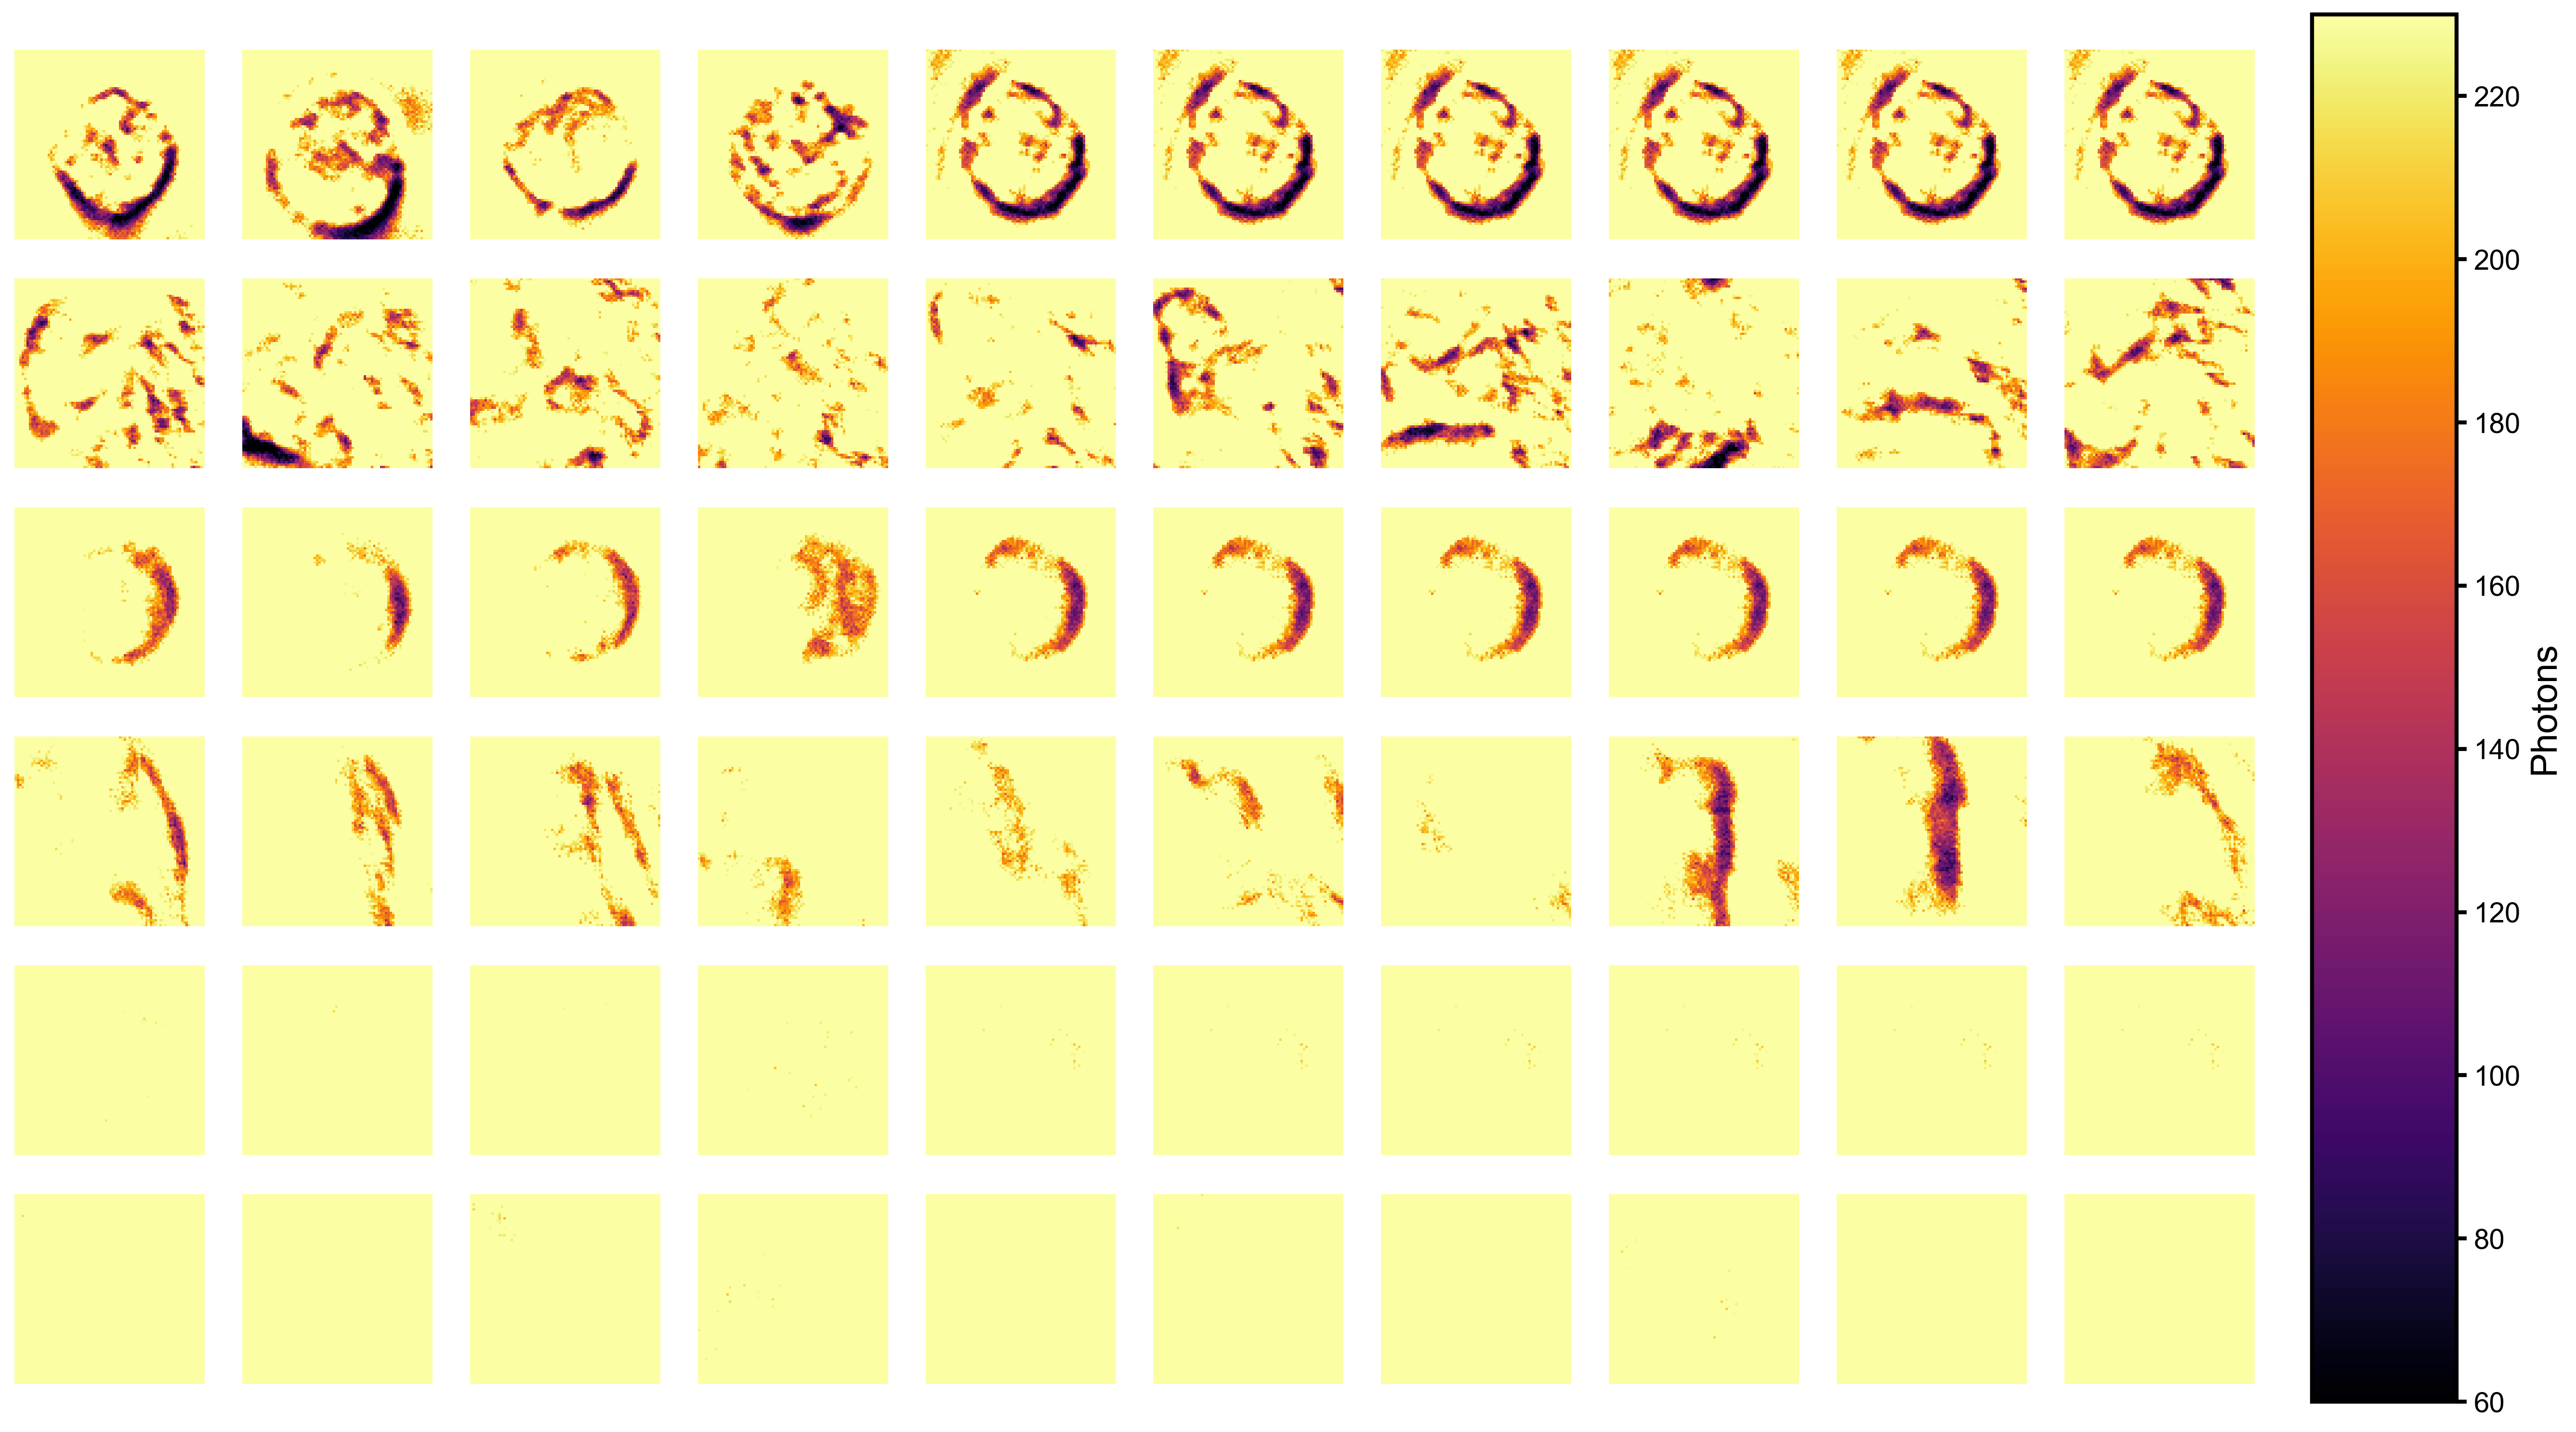

In [4]:
image_samples = image_samples_pcnn

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_pixel_cnn' + '.pdf', transparent=True)